<a href="https://colab.research.google.com/github/kyalan/CUHK-STAT5106-2020/blob/main/Week_12_Open_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Import files from your PC to colab

In [2]:
from google.colab import files
uploaded = files.upload()
for k, v in uploaded.items():
    open(k, 'wb').write(v)

Saving 1_EYFejGUjvjPcc4PZTwoufw.jpeg to 1_EYFejGUjvjPcc4PZTwoufw (1).jpeg


In [3]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
image_path = '1_EYFejGUjvjPcc4PZTwoufw.jpeg'
img = mpimg.imread(image_path)
# np.array
print(img.shape) 

(586, 872, 3)


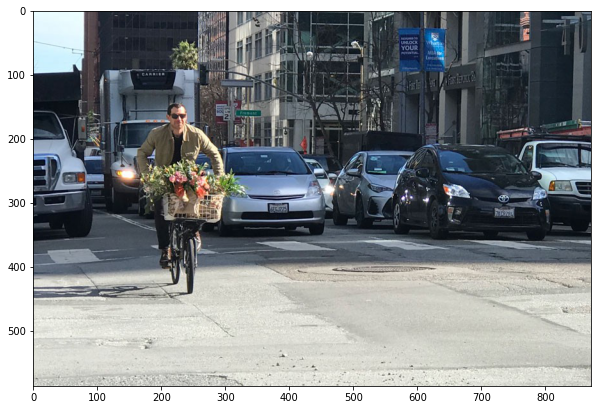

In [4]:
fig = plt.figure(figsize=(10,8))
plt.imshow(img)

# Data Pre-processing

In [40]:
import numpy as np

# img_np = img / 255.0
img_np = img.copy()
img_np = np.expand_dims(img_np, axis=0).astype(np.uint8)

# Import Model

In [41]:
try:
    %tensorflow_version 2.x 
except: 
    pass

import tensorflow as tf
import tensorflow_hub as hub
import pathlib

print('Tensorflow\'s version: {}'.format(tf.__version__))

Tensorflow's version: 2.4.1


### 1. Loading Models from specific sites

In [7]:
# Ref: https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name
        , origin=base_url + model_file
        , untar=True)
    model_dir = pathlib.Path(model_dir)/"saved_model"

    print('{} is going to be loaded.'.format(str(model_dir)))
    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

In [8]:
# model list: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
# here is the example: mask_rcnn_inception_v2_coco
# http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
# model = load_model('mask_rcnn_inception_v2_coco_2018_01_28')

In [9]:
# print(model.inputs)
# print(model.output_dtypes)
# print(model.output_shapes)

### 2. Loading Model from tf.hub

In [42]:
# We are going to load the model - Mask R-CNN Object detection model - Inception Resnet v2 1024x1024
# with Model site: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1 
def load_hub_model(model_site):
    model = hub.load(model_site)
    return model

In [43]:
model = load_hub_model('https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1')

# Get influence from the model

In [44]:
results = model(tf.convert_to_tensor(img_np))
# all outputs are tensor. convert them to numpy.
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['rpn_box_encodings', 'box_classifier_features', 'raw_detection_scores', 'proposal_boxes_normalized', 'detection_multiclass_scores', 'num_proposals', 'anchors', 'detection_boxes', 'image_shape', 'rpn_objectness_predictions_with_background', 'detection_scores', 'detection_masks', 'rpn_features_to_crop', 'detection_anchor_indices', 'refined_box_encodings', 'mask_predictions', 'final_anchors', 'detection_classes', 'rpn_box_predictor_features', 'num_detections', 'class_predictions_with_background', 'raw_detection_boxes', 'proposal_boxes'])


In [45]:
# print
for key, value in results.items():
    print(key, ':', value.shape, value.dtype)

# 5 objects: detection_classes , num_detections , detection_boxes , detection_scores, detection_masks

rpn_box_encodings : (1, 49152, 4) <dtype: 'float32'>
box_classifier_features : (300, 9, 9, 1536) <dtype: 'float32'>
raw_detection_scores : (1, 300, 91) <dtype: 'float32'>
proposal_boxes_normalized : (1, 300, 4) <dtype: 'float32'>
detection_multiclass_scores : (1, 100, 91) <dtype: 'float32'>
num_proposals : (1,) <dtype: 'float32'>
anchors : (49152, 4) <dtype: 'float32'>
detection_boxes : (1, 100, 4) <dtype: 'float32'>
image_shape : (4,) <dtype: 'float32'>
rpn_objectness_predictions_with_background : (1, 49152, 2) <dtype: 'float32'>
detection_scores : (1, 100) <dtype: 'float32'>
detection_masks : (1, 100, 33, 33) <dtype: 'float32'>
rpn_features_to_crop : (1, 64, 64, 1088) <dtype: 'float32'>
detection_anchor_indices : (1, 100) <dtype: 'float32'>
refined_box_encodings : (300, 90, 4) <dtype: 'float32'>
mask_predictions : (100, 90, 33, 33) <dtype: 'float32'>
final_anchors : (1, 300, 4) <dtype: 'float32'>
detection_classes : (1, 100) <dtype: 'float32'>
rpn_box_predictor_features : (1, 64, 64,

# Visualizing those boxes

In [16]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [17]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1643309 sha256=1cc4dd1f64c26e7a509341f684a889462c64ab80b1500eed966cb29782273e34
  Stored in directory: /tmp/pip-ephem-wheel-cache-khzfw9ne/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [24]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [19]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

In [46]:
# Handle models with masks:
label_id_offset = 0
image_np_with_mask = img_np.copy()

# Handle models with masks:
if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              img_np.shape[1], img_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

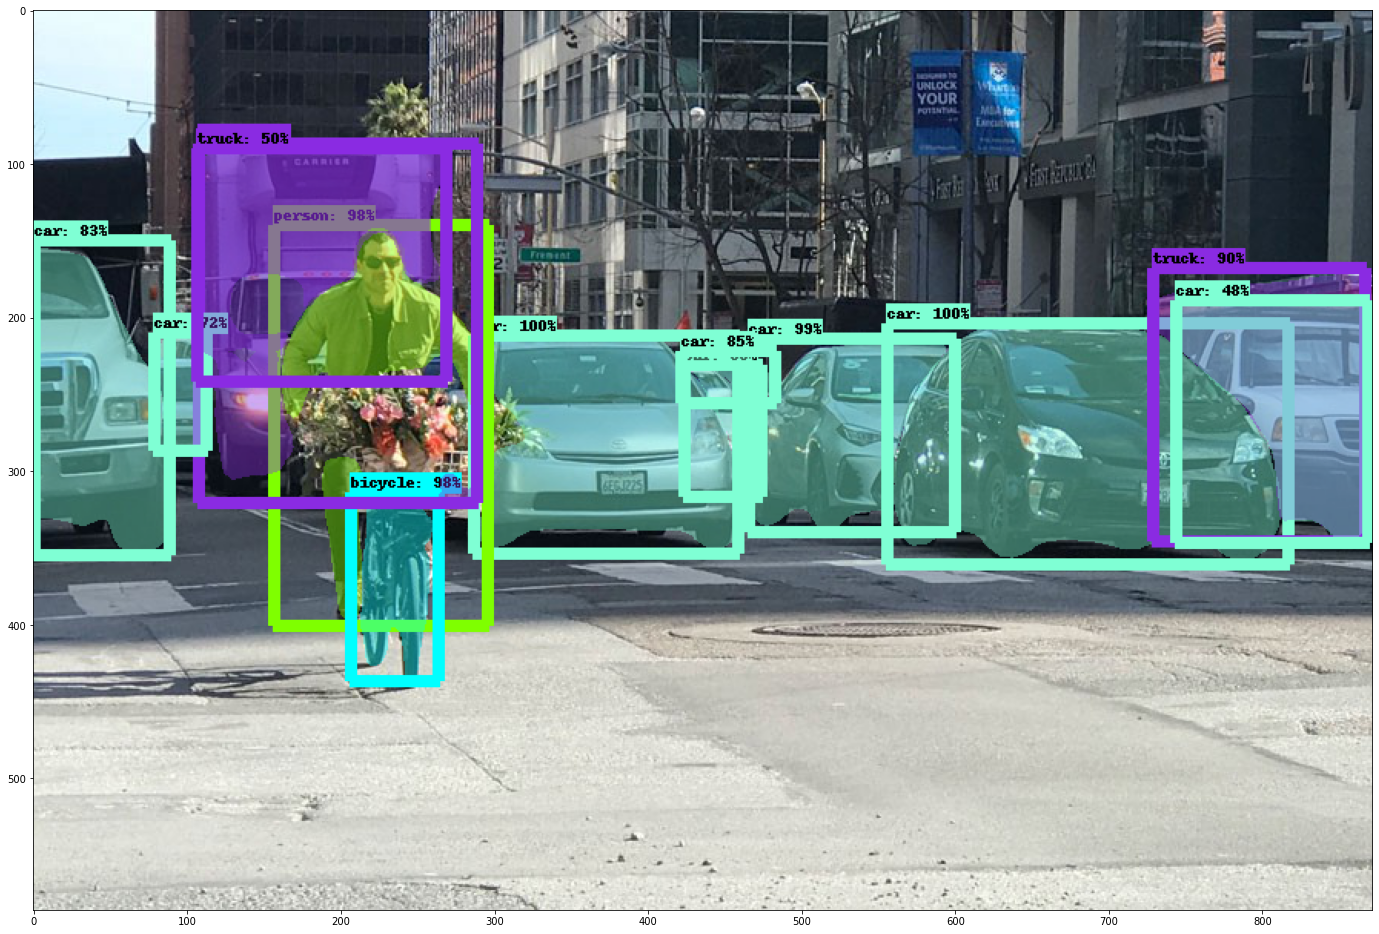

In [47]:
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()